In [1]:
import numpy as np
import pandas as pd
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt

import itertools

## With stratification

Population is divided into groups (e.g. age groups), optionally with group-dependent parameters (in the example `beta` is stratified) and with interaction among them, defined by `nc`.

### As simple and scipy-close as possible

In [2]:
def integrate(t, y, parameters, nc):
    """Basic SIR model with interaction nc"""
    
    # unpacking need to be done explicitly
    S, I, R = y.reshape(3, 2)
    beta, gamma = parameters
    
    # Model equations
    N = S + I + R
    dS = nc @ (-beta*S*I/N)
    dI = nc @ (beta*S*I/N) - gamma*I
    dR = gamma*I

    return np.array([dS, dI, dR]).flatten()

# ... time, parameters and initial conditions
time = [0, 150]
parameters = {"beta": np.array([0.5, 0.4]), "gamma": 0.3}  # same order as definition
initial_states = {"S": [440000, 350000], "I": [20, 10], "R": [0, 0]} # same order as definition
nc = np.array([[0.9, 0.2], [0.8, 0.1]])

#  -> runs model with scipy directly.
output_ = solve_ivp(integrate, time, 
                   list(itertools.chain(*initial_states.values())), 
                   args=(list(parameters.values()), nc))

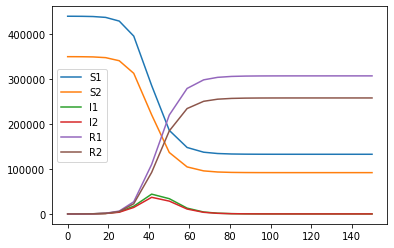

In [3]:
S1, S2, I1, I2, R1, R2 = output_["y"]
plt.plot(output_["t"], S1, label="S1")
plt.plot(output_["t"], S2, label="S2")
plt.plot(output_["t"], I1, label="I1")
plt.plot(output_["t"], I2, label="I2")
plt.plot(output_["t"], R1, label="R1")
plt.plot(output_["t"], R2, label="R2")
plt.legend()

### Abstract away the boilerplate in Base class and define a new model as subclass 

In [4]:
class BaseModel:
    
    state_names = None
    parameter_names = None
    parameters_stratified_names = None 
    stratification = None
   
    def __init__(self, states, parameters):
        """"""
        self.parameters = parameters
        self.initial_states = states
        
        if self.stratification:
            self.stratification_size = parameters[self.stratification].shape[0]
        else:
            self.stratification_size = 1

    def integrate(self):
        """to overwrite in subclasses"""
        raise NotImplementedError        
        
    def create_fun(self):
        """Convert integrate statement to scipy-compatible function"""

        def func(t, y, *pars):
            """As used by scipy -> flattend in, flattend out"""
            
            # for the moment assume sequence of parameters, vars,... is correct
            y_reshaped = y.reshape((len(self.state_names), self.stratification_size)) 
            dstates = self.integrate(t, *y_reshaped, *pars) 
            return np.array(dstates).flatten()

        return func
    
    def sim(self, time):
        """"""        
        fun = self.create_fun()
        output = solve_ivp(fun, time, 
                           list(itertools.chain(*self.initial_states.values())), 
                           args=list(self.parameters.values()))
        return output["t"], self.array_to_variables(output["y"]) # map back to variable names
            
    def array_to_variables(self, y):
        """Convert array (used by scipy) to dictionary (used by model API)"""
        return dict(zip(self.state_names, y.reshape(len(self.state_names), 
                                                    self.stratification_size, -1)))

In [5]:
# User (model developer) specifies...

# ... a model subclass
class SIR_S(BaseModel):

    # ...state variables and parameters
    state_names = ['S', 'I', 'R']
    parameter_names = ['gamma']
    parameters_stratified_names = ['beta']  
    stratification = 'nc'
    
    # ..transitions/equations
    @staticmethod
    def integrate(t, S, I, R, gamma, beta, nc):  
        """Basic SIR model"""

        # Model equations
        N = S + I + R
        dS = nc @ (-beta*S*I/N)
        dI = nc @ (beta*S*I/N) - gamma*I
        dR = gamma*I
        
        return dS, dI, dR

In [6]:
# Model user defines...

# ... parameters and initial conditions
nc = np.array([[0.9, 0.2], [0.8, 0.1]])  
parameters = {"gamma": 0.3, "beta": np.array([0.5, 0.4]), "nc": nc}  
initial_states = {"S": [440000, 350000], "I": [20, 10], "R": [0, 0]}

# -> user initiates the model
sir_model = SIR_S(initial_states, parameters)

# -> user runs a simulation for a defined time period
time = [0, 150]
t, output = sir_model.sim(time)

# -> user can do fit, mc,... using the model class instance `sir_model`

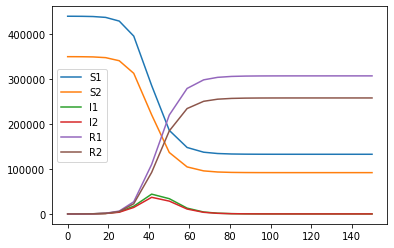

In [7]:
plt.plot(t, output["S"][0,:], label="S1")
plt.plot(t, output["S"][1,:], label="S2")
plt.plot(t, output["I"][0,:], label="I1")
plt.plot(t, output["I"][1,:], label="I2")
plt.plot(t, output["R"][0,:], label="R1")
plt.plot(t, output["R"][1,:], label="R2")
plt.legend()

#### Model developer not interested in supporting stratified...

But using the same `BaseModel`

In [8]:
# User (model developer) specifies...

# ... state transitions in a subclass
class SIR(BaseModel):

    # state variables and parameters
    state_names = ['S', 'I', 'R']
    parameter_names = ['beta', 'gamma']
    
    @staticmethod
    def integrate(t, S, I, R, beta, gamma):  # All variables and parameters... will be long list or arguments(!)
        """Basic SIR model"""
        N = S + I + R
        dS = -beta*S*I/N
        dI = beta*S*I/N - gamma*I
        dR = gamma*I
        
        return dS, dI, dR

# ... parameters and initial conditions
parameters = {"beta": 0.5, "gamma": 0.3}
initial_states = {"S": [7900000], "I": [10], "R": [0]} # states as array|list

# -> user initiates the model
sir_model = SIR(initial_states, parameters)

# -> user runs a simulation for a defined time period
time = [0, 150]
t, output = sir_model.sim(time)

# -> user can do fit, mc,... using the model class instance `sir_model`

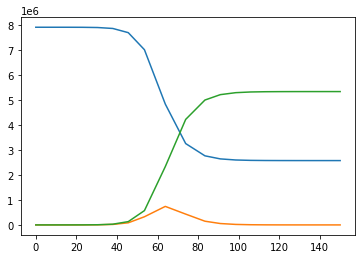

In [9]:
fig, ax = plt.subplots()
ax.plot(t, output["S"].flatten())
ax.plot(t, output["I"].flatten())
ax.plot(t, output["R"].flatten())

## Age based SEIRS

In [10]:
class SEIRSAge(BaseModel):

    # ...state variables and parameters
    state_names = ['S', 'E', 'I', 'A', 'M', 'C', 'Cmirec', 'Cicurec', 'Mi', 
                   'ICU', 'R', 'D', 'SQ', 'EQ', 'IQ', 'AQ', 'MQ', 'RQ']
    parameter_names = ['beta', 'sigma', 'omega', 'zeta', 'a', 'm', 'da', 'dm', 'dc', 'dmi', 'dICU', 'dICUrec', 
                  'dmirec', 'dhospital', 'maxICU', 'totalTests', 'psi_FP', 'psi_PP', 'dq']
    parameters_stratified_names = ['h', 'c', 'm0','mi']  
    stratification = 'nc'
    
    # ..transitions/equations
    @staticmethod
    def integrate(t, S, E, I, A, M, C, Cmirec, Cicurec, Mi, ICU, R, D, SQ, EQ, IQ, AQ, MQ, RQ, 
                  beta, sigma, omega, zeta, a, m, da, dm, dc, dmi, dICU, dICUrec, 
                  dmirec, dhospital, maxICU, totalTests, psi_FP, psi_PP, dq, h, c, m0, mi, Nc):  
        """Basic SIR model"""

        # Model equations
        Ctot = C + Cmirec + Cicurec
        # calculate total population per age bin using 2D array
        N = S + E + I + A + M + Ctot + Mi + ICU + R + SQ + EQ + IQ + AQ + MQ + RQ
        # calculate the test rates for each pool using the total number of available tests
        nT = S + E + I + A + M + R
        theta_S = totalTests/nT
        theta_S[theta_S > 1] = 1
        theta_E = totalTests/nT
        theta_E[theta_E > 1] = 1
        theta_I = totalTests/nT
        theta_I[theta_I > 1] = 1
        theta_A = totalTests/nT
        theta_A[theta_A > 1] = 1
        theta_M = totalTests/nT
        theta_M[theta_M > 1] = 1
        theta_R = totalTests/nT
        theta_R[theta_R > 1] = 1
        # calculate rates of change using the 2D arrays
        dS  = - beta*np.matmul(Nc,((I+A)/N)*S) - theta_S*psi_FP*S + SQ/dq + zeta*R
        dE  = beta*np.matmul(Nc,((I+A)/N)*S) - E/sigma - theta_E*psi_PP*E
        dI = (1/sigma)*E - (1/omega)*I - theta_I*psi_PP*I
        dA = (a/omega)*I - A/da - theta_A*psi_PP*A
        dM = (m/omega)*I - M*((1-h)/dm) - M*h/dhospital - theta_M*psi_PP*M
        dC = c*(M+MQ)*(h/dhospital) - C*(1/dc)
        dCmirec = Mi/dmi- Cmirec*(1/dmirec)
        dCicurec = ((1-m0)/dICU)*ICU - Cicurec*(1/dICUrec)
        dMi = mi*(M+MQ)*(h/dhospital) - Mi/dmi
        dICUstar = (1-c-mi)*(M+MQ)*(h/dhospital) - ICU/dICU
        dR  = A/da + ((1-h)/dm)*M + C*(1/dc) + Cmirec*(1/dmirec) + Cicurec*(1/dICUrec) + AQ/dq + MQ*((1-h)/dm) + RQ/dq - zeta*R
        dD  = (m0/dICU)*ICU
        dSQ = theta_S*psi_FP*S - SQ/dq
        dEQ = theta_E*psi_PP*E - EQ/sigma
        dIQ = theta_I*psi_PP*I + (1/sigma)*EQ - (1/omega)*IQ
        dAQ = theta_A*psi_PP*A + (a/omega)*IQ - AQ/dq
        dMQ = theta_M*psi_PP*M + (m/omega)*IQ - ((1-h)/dm)*MQ - (h/dhospital)*MQ
        dRQ = theta_R*psi_FP*R - RQ/dq
        
        return (dS, dE, dI, dA, dM, dC, dCmirec, dCicurec, dMi, 
                dICUstar, dR, dD, dSQ, dEQ, dIQ, dAQ, dMQ, dRQ)

In [11]:
Nc_total = np.loadtxt("../data/raw/Interaction_matrices/Belgium/BELtotal.txt", dtype='f', delimiter='\t')
initN = np.loadtxt("../data/raw/Interaction_matrices/Belgium/BELagedist_10year.txt", dtype='f', delimiter='\t')

h = np.array([0.0205,0.0205,0.1755,0.1755,0.2115,0.2503,0.3066,0.4033,0.4770])
icu = np.array([0,0,0.0310,0.0310,0.055,0.077,0.107,0.1685,0.1895])
r = icu/h

In [12]:
# ... parameters and initial conditions
levels = initN.size
nc = Nc_total
parameters = {'beta': 0.0622, 'sigma': 3.2, 'omega': 2.0, 'zeta': 0, 'a': 0.43, 'm': 1-0.43, 'da': 7, 'dm': 7, 'dc': 8, 'dmi': 8, 'dICU': 8, 'dICUrec': 7, 
              'dmirec': 7, 'dhospital': 4, 'maxICU': 2000, 'totalTests': 0, 'psi_FP': 0, 'psi_PP': 1, 'dq': 14, 'h': h, 
              'c': 1-r, 'm0': np.ones(levels)*0.50, 'mi': 0.5*r, 'nc': nc}  

initial_states = {'S': initN, 'E': np.ones(levels), 'I': np.zeros(levels), 'A': np.zeros(levels), 'M': np.zeros(levels), 
                  'C': np.zeros(levels), 'Cmirec': np.zeros(levels), 'Cicurec': np.zeros(levels), 'Mi': np.zeros(levels), 
                  'ICU': np.zeros(levels), 'R': np.zeros(levels), 'D': np.zeros(levels), 'SQ': np.zeros(levels), 
                  'EQ': np.zeros(levels), 'IQ': np.zeros(levels), 'AQ': np.zeros(levels), 'MQ': np.zeros(levels), 
                  'RQ': np.zeros(levels)}

In [13]:
# -> user initiates the model
sir_model = SEIRSAge(initial_states, parameters)

# -> user runs a simulation for a defined time period
time = [0, 200]
t, output = sir_model.sim(time)

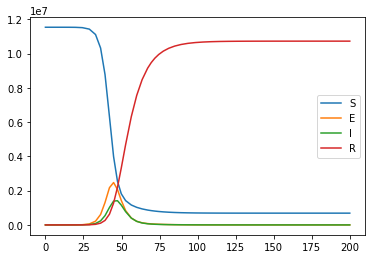

In [14]:
plt.plot(t, output["S"].sum(axis=0), label="S")
plt.plot(t, output["E"].sum(axis=0), label="E")
plt.plot(t, output["I"].sum(axis=0), label="I")
plt.plot(t, output["R"].sum(axis=0), label="R")
plt.legend()